# Reflex Agent vs Goal-Based Agent

## What is an Agent?

In AI, an **agent** is anything that perceives its environment through sensors and acts upon that environment through actuators. Think of a robot vacuum, a self-driving car, or even a chess-playing program - they all sense their surroundings and take actions based on what they perceive.

Agents can be categorized by how they make decisions. In this demo, we'll compare two fundamental types:
- **Reflex Agents**: React immediately to current perceptions
- **Goal-Based Agents**: Plan actions to achieve specific objectives

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import time
from IPython.display import clear_output

%matplotlib inline

# Grid setup
GRID_SIZE = 5
START_POS = (0, 0)

def generate_random_position(excluded_positions):
    """
    Generates a random grid position that doesn't overlap with already occupied cells.
    Keeps trying different random positions until finding an empty one.
    """
    while True:
        position = (random.randint(0, GRID_SIZE - 1), 
                   random.randint(0, GRID_SIZE - 1))
        if position not in excluded_positions:
            return position

# Set up world: agent starts at (0,0), goal and dirt are placed randomly
GOAL_POS = generate_random_position([START_POS])
DIRTY_CELL = generate_random_position([START_POS, GOAL_POS])

print(f"Config -> Start: {START_POS} | Goal: {GOAL_POS} | Dirt: {DIRTY_CELL}")


Random configuration generated:
  Start: (0, 0)
  Goal: (4, 3)
  Dirty cell: (2, 3)


In [12]:
# GridWorld Environment
class GridWorld:
    """
    A 2D grid environment where an agent can move in four directions and clean dirt.
    Tracks the agent's position, goal location, and whether dirt still exists.
    """
    
    # Maps each direction string to its coordinate offset (dx, dy)
    MOVES = {
        'up': (0, 1),
        'down': (0, -1),
        'right': (1, 0),
        'left': (-1, 0)
    }
    
    def __init__(self, size, start, goal, dirty):
        self.size = size
        self.start = start
        self.goal = goal
        self.dirty = dirty
        self.agent_pos = start
        self.is_dirty = True
    
    def reset(self):
        """Resets the environment to initial state"""
        self.agent_pos = self.start
        self.is_dirty = True
    
    def move_agent(self, action):
        """
        Processes the agent's action - either cleaning dirt or moving in a direction.
        Movement is bounded to stay within the grid.
        """
        if action == 'clean' and self.agent_pos == self.dirty:
            self.is_dirty = False
            return
        
        if action in self.MOVES:
            dx, dy = self.MOVES[action]
            # Clamp new position to grid boundaries
            new_x = max(0, min(self.agent_pos[0] + dx, self.size - 1))
            new_y = max(0, min(self.agent_pos[1] + dy, self.size - 1))
            self.agent_pos = (new_x, new_y)
    
    def at_goal(self):
        """Returns True if the agent is currently at the goal position"""
        return self.agent_pos == self.goal

## The Environment

Before we build agents, we need a world for them to live in. Our environment is a simple 5x5 grid with:
- An **agent** that can move in four directions or clean
- A **goal** location the agent needs to reach
- A **dirty cell** that should be cleaned

This environment enforces boundaries (the agent can't walk off the grid) and tracks whether the dirt has been cleaned.

## Agent Type 1: Reflex Agent

**Reflex agents** are the simplest type of agent. They follow a basic condition-action rule:

**IF** (condition) **THEN** (action)

Key characteristics:
- **No memory**: Doesn't remember where it's been
- **No planning**: Doesn't think ahead
- **Pure reaction**: Responds only to what it perceives right now

In our case:
- IF standing on dirt → THEN clean
- ELSE → move randomly

This approach works for simple tasks but is inefficient when goals require planning. The agent might wander aimlessly for a long time before accidentally reaching the goal.

In [ ]:
# REFLEX AGENT: Reactive behavior with no planning
def reflex_agent(env):
    """
    A simple reactive agent that responds only to current conditions.
    Cleans if standing on dirt, otherwise moves in a random direction.
    Has no memory of past states or goals.
    """
    # Clean the dirt if standing on it
    if env.agent_pos == env.dirty and env.is_dirty:
        return 'clean'
    
    # Otherwise move randomly
    return random.choice(['up', 'down', 'left', 'right'])

## Agent Type 2: Goal-Based Agent

**Goal-based agents** are smarter - they consider the future consequences of their actions and choose the path that achieves their goal.

Key characteristics:
- **Goal awareness**: Knows what it wants to achieve
- **Planning**: Thinks about how to get there
- **Efficient**: Takes the shortest path to the goal

How it works:
1. Identify the goal (or sub-goal if dirt needs cleaning first)
2. Calculate which direction moves closer to the target
3. Take that action

This agent uses **Manhattan distance** - it moves horizontally until aligned with the target, then moves vertically. This guarantees it will reach the goal in the minimum number of steps.

**Why is this better?** Instead of hoping to randomly stumble onto the goal, the agent deliberately navigates toward it. This is the foundation of more complex AI systems like GPS navigation or pathfinding in games.

In [ ]:
# GOAL-BASED AGENT: Plans actions to reach objectives
def goal_based_agent(env):
    """
    An agent that plans its path toward a target.
    Prioritizes cleaning dirt first, then navigates directly to the goal.
    Uses a Manhattan distance approach (horizontal then vertical movement).
    """
    # Clean dirt if currently standing on it
    if env.agent_pos == env.dirty and env.is_dirty:
        return 'clean'
    
    # Set target: dirt if uncleaned, otherwise the goal
    target = env.dirty if env.is_dirty else env.goal
    
    x, y = env.agent_pos
    target_x, target_y = target
    
    # Move horizontally first, then vertically (L-shaped path)
    if x < target_x:
        return 'right'
    if x > target_x:
        return 'left'
    if y < target_y:
        return 'up'
    if y > target_y:
        return 'down'
    
    return 'stop'

## Visualizing the Grid

To watch the agents in action, we need to draw the grid world. Here's how the visualization works:

**Grid Structure**: We use matplotlib to create a 5x5 grid where each cell is a square. Each cell represents a position where the agent can be.

**Color Coding**:
- **Green glow** = Goal position (where the agent needs to reach)
- **Orange glow** = Dirty cell (needs cleaning)
- **Blue circle with 'A'** = Agent's current position
- **Dark cells** = Empty spaces

The visualization updates at each step so you can see the agent move in real-time. We also add a "glow" effect around important elements to make them stand out - this is done by drawing the same shape twice with different transparency levels.

In [15]:
# Visualization function with dark theme styling
def visualize_grid(env, agent_type, step_num, ax):
    """
    Renders the grid world state with the agent, goal, and dirt.
    Uses a dark background with neon-colored elements for visibility.
    """
    ax.clear()
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.set_aspect('equal')
    ax.set_facecolor('#1a1a1a')
    
    # Color-code by agent type: red for reflex, cyan for goal-based
    title_color = '#ff6b6b' if 'REFLEX' in agent_type else '#4ecdc4'
    ax.set_title(f'{agent_type} - Step {step_num}', 
                 fontsize=16, fontweight='bold', color=title_color, pad=20)
    
    # Draw grid cells
    for i in range(env.size):
        for j in range(env.size):
            cell = patches.Rectangle((i, j), 1, 1, 
                                     linewidth=2, 
                                     edgecolor='#333333',
                                     facecolor='#0d0d0d')
            ax.add_patch(cell)
    
    # Draw goal with green glow
    goal_cell = patches.Rectangle(env.goal, 1, 1, linewidth=3, 
                                  edgecolor='#00ff41', facecolor='#003d1a',
                                  alpha=0.9)
    ax.add_patch(goal_cell)
    
    goal_glow = patches.Rectangle(env.goal, 1, 1, linewidth=8,
                                  edgecolor='#00ff41', facecolor='none',
                                  alpha=0.3)
    ax.add_patch(goal_glow)
    
    ax.text(env.goal[0] + 0.5, env.goal[1] + 0.5, '★ GOAL ★', 
            ha='center', va='center', fontweight='bold', 
            color='#00ff41', fontsize=11)
    
    # Draw dirty cell with orange glow (only if still dirty)
    if env.is_dirty:
        dirty_cell = patches.Rectangle(env.dirty, 1, 1, linewidth=3,
                                       edgecolor='#ff6b35', facecolor='#4a1a0a',
                                       alpha=0.9)
        ax.add_patch(dirty_cell)
        
        dirty_glow = patches.Rectangle(env.dirty, 1, 1, linewidth=8,
                                       edgecolor='#ff6b35', facecolor='none',
                                       alpha=0.3)
        ax.add_patch(dirty_glow)
        
        ax.text(env.dirty[0] + 0.5, env.dirty[1] + 0.5, 'DIRTY',
                ha='center', va='center', fontsize=10, 
                fontweight='bold', color='#ff6b35')
    
    # Draw agent with blue glow effect
    agent_x, agent_y = env.agent_pos[0] + 0.5, env.agent_pos[1] + 0.5
    
    agent_glow = patches.Circle((agent_x, agent_y), 0.4, 
                                color='#4169e1', alpha=0.3, zorder=9)
    ax.add_patch(agent_glow)
    
    agent_circle = patches.Circle((agent_x, agent_y), 0.3, 
                                  color='#1e90ff', zorder=10,
                                  edgecolor='#00bfff', linewidth=2)
    ax.add_patch(agent_circle)
    
    ax.text(agent_x, agent_y, 'A',
            ha='center', va='center', fontsize=14, 
            fontweight='bold', color='white', zorder=11)
    
    # Clean look: remove tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add border
    for spine in ax.spines.values():
        spine.set_edgecolor('#666666')
        spine.set_linewidth(2)


In [16]:
# Main simulation loop
def run_agent(env, agent_func, agent_type, max_steps=30):
    """
    Runs the agent simulation for a maximum number of steps.
    Displays each step visually and stops when the goal is reached.
    """
    env.reset()
    
    for step in range(max_steps):
        clear_output(wait=True)
        
        fig, ax = plt.subplots(figsize=(8, 8), facecolor='#0a0a0a')
        
        visualize_grid(env, agent_type, step, ax)
        
        # Check for goal completion
        if env.at_goal():
            success_box = dict(boxstyle='round,pad=0.5', 
                             facecolor='#1a1a1a', 
                             edgecolor='#00ff41', 
                             linewidth=2)
            ax.text(env.size / 2, -0.7, f'Goal Reached in {step} steps!',
                    ha='center', fontsize=14, color='#00ff41', 
                    fontweight='bold', bbox=success_box)
            plt.show()
            break
        
        plt.show()
        time.sleep(0.5)  # Pause for visualization
        plt.close()
        
        # Get action from agent and execute it
        action = agent_func(env)
        env.move_agent(action)

In [17]:
# Create environment
env = GridWorld(GRID_SIZE, START_POS, GOAL_POS, DIRTY_CELL)
print(f"Environment: {GRID_SIZE}x{GRID_SIZE} grid initialized")

Environment created with:
  Grid size: 5x5
  Start position: (0, 0)
  Goal position: (4, 3)
  Dirty cell: (2, 3)


## Seeing the Agents in Action

Now let's watch both agents solve the same problem. Notice:
- How many steps each one takes
- The path each one follows
- The difference in efficiency

Run each agent below and compare their behavior!

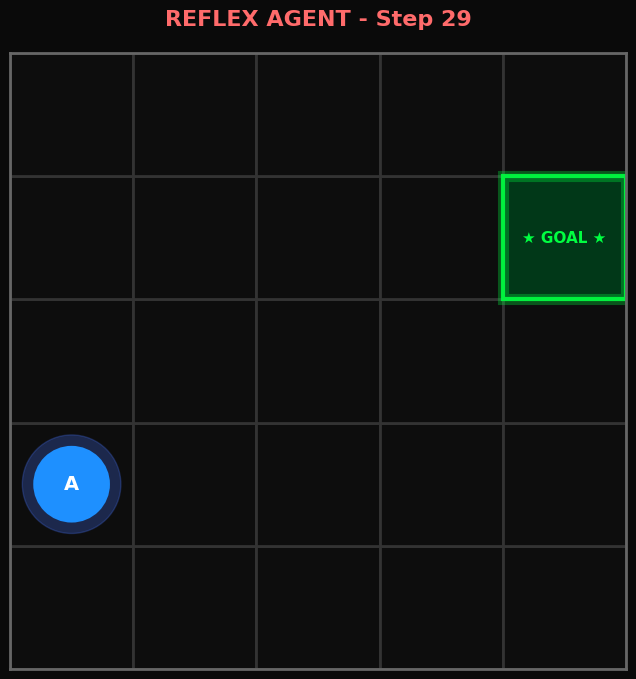

In [18]:
# Run REFLEX AGENT - random movement, no planning
run_agent(env, reflex_agent, "REFLEX AGENT", max_steps=30)

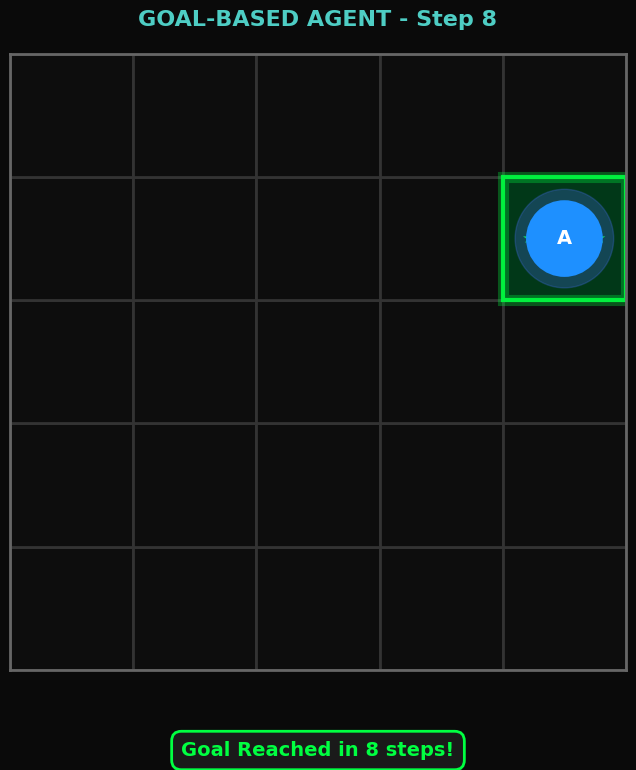

In [19]:
# Run GOAL-BASED AGENT - efficient planning
run_agent(env, goal_based_agent, "GOAL-BASED AGENT", max_steps=30)

## Key Takeaways

### Reflex Agent
- **Advantages**: Simple, fast reactions, easy to implement
- **Disadvantages**: Inefficient, unpredictable, can't handle complex tasks
- **Best for**: Simple environments where immediate reactions are sufficient

### Goal-Based Agent  
- **Advantages**: Efficient, predictable, reaches goals reliably
- **Disadvantages**: More complex, needs goal representation, requires planning computation
- **Best for**: Tasks requiring navigation, optimization, or multi-step solutions


## Questions for Reflection

Think deeply about these questions:

**Question 1: The Randomness Paradox**  
If you run the reflex agent 1000 times, it will eventually find optimal or near-optimal paths by pure chance. Given enough time, could a reflex agent with random movement actually outperform a goal-based agent that takes a predictable path? What if the environment has moving obstacles that the goal-based agent's plan doesn't account for? When might "dumb luck" beat "smart planning"?

**Question 2: The Intelligence Question**  
Our goal-based agent appears "smarter" because it reaches the goal faster - but is it really intelligent, or is it just following a more sophisticated set of rules? It doesn't understand what a "goal" is; it just calculates distances and moves accordingly. If we define intelligence as "the ability to achieve goals," then is a heat-seeking missile intelligent? Where do we draw the line between programmed behavior and true intelligence?

*Hint: There are no right answers here - that's what makes them interesting!*